## Burgers equation
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & t \in[0, 1], ~~ x \in [-1, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import torch.nn.functional as F

import scipy
import matplotlib.gridspec as gridspec

class Net(nn.Module):
    def __init__(self, neuron): 
        super(Net, self).__init__()

        self.input_layer = nn.Linear(2, neuron)
        # self.hidden_layer1 = nn.Linear(neuron,int(neuron/2)) 
        self.hidden_layer1 = nn.Linear(neuron,neuron) 
        self.hidden_layer2 = nn.Linear(neuron, neuron)  
        self.output_layer = nn.Linear(neuron, 1)
        

    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer1(out))
        out = torch.tanh(self.hidden_layer2(out))
        out_final = self.output_layer(out)
        return out_final


# Define the neural network architecture
#NN = nn.Sequential(nn.Linear(2, neurons), nn.Sigmoid(), nn.Linear(neurons, 1, bias=True))


pred_1 = Net(50)
pred_2 = Net(100)
pred_3 = Net(150)

# Define the optimizer
adam_1 = torch.optim.Adam(pred_1.parameters(), lr=0.01)
adam_2 = torch.optim.Adam(pred_2.parameters(), lr=0.01)
adam_3 = torch.optim.Adam(pred_3.parameters(), lr=0.01)
#mse = torch.nn.MSELoss(reduction='mean') 

# initialization
w = torch.tensor(1.0, requires_grad=True)
# w1 = torch.tensor(1.0, requires_grad=True)
# w2 = torch.tensor(1.0, requires_grad=True)

data = scipy.io.loadmat('/Users/jiangwengyao/Desktop/burgers_shock.mat')

# t_collocation = data['t'].flatten()[:,None]
# x_collocation = data['x'].flatten()[:,None]

t_collocation = np.arange(0, 1, 0.01).reshape(-1, 1)
x_collocation = np.linspace(-1, 1, 256).reshape(-1, 1)

T, X = np.meshgrid(t_collocation, x_collocation)

# t_collocation = np.linspace(0.0, 1.0, 256).reshape(-1, 1)
# x_collocation = np.linspace(-1.0, 1.0, 256).reshape(-1, 1)

# t = torch.tensor(t_collocation, dtype=torch.float32, requires_grad=True)
x = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

TX_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))

spatial_coords = torch.tensor(TX_star, dtype=torch.float32, requires_grad=True)

#spatial_coords = torch.cat([t, x], 1)

t_ran = np.random.uniform(low=0.0, high=1.0, size=(256, 1))
# x_ran = np.random.uniform(low=-1.0, high=1.0, size=(256, 1))

t = Variable(torch.from_numpy(t_ran).float(), requires_grad=True)
# X = Variable(torch.from_numpy(x_ran).float(), requires_grad=True)
#print(torch.cat([x, y],1))

z_0 = torch.zeros_like(x)
z_1 = torch.ones_like(x)
z_2 = torch.full_like(x, -1)

bc_1 = torch.cat((z_0, x), dim=1)
bc_2 = torch.cat((t, z_1), dim=1)
bc_3 = torch.cat((t, z_2), dim=1)

t_1 = 0.25*torch.ones_like(t)
t_2 = 0.50*torch.ones_like(t)
t_3 = 0.75*torch.ones_like(t)

nnt_1 = torch.cat((t_1, x), dim=1)
nnt_2 = torch.cat((t_2, x), dim=1)
nnt_3 = torch.cat((t_3, x), dim=1)

def bc_function(t, x):
    # Define the bc function
    f = -torch.sin(np.pi * x)
    return f

# Define the boundary condition function (homogeneous Dirichlet boundary condition)
def boundary_condition(t, x):
    return torch.zeros_like(x)  # Zero value boundary condition


def loss_function(pred, inputs):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    pde_residual = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    boundary_residual_1 = pred(bc_1) - bc_function(t, x)
    boundary_residual_2 = pred(bc_2) - boundary_condition(t, x)
    boundary_residual_3 = pred(bc_3) - boundary_condition(t, x)


    # Total loss
    total_loss = torch.mean(pde_residual**2)+torch.mean(boundary_residual_1**2)+torch.mean(boundary_residual_2**2)+torch.mean(boundary_residual_3**2)
    
    return total_loss

In [10]:
import scipy
import matplotlib.gridspec as gridspec

data = scipy.io.loadmat('/Users/jiangwengyao/Desktop/burgers_shock.mat')
Exact = np.real(data['usol']).T


def train(pred, optimizer, epochs):
    lossList = []
    epochList = []
    pred_nn_1, pred_nn_2, pred_nn_3 = [], [], []
        
#   without weight
    for epoch in range(epochs+1):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_function(pred, spatial_coords)  # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step() 
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}") 
        lossList.append(loss_val.item())
        epochList.append(epoch)
        pred_nn_1.append(pred(nnt_1).detach().numpy())
        pred_nn_2.append(pred(nnt_2).detach().numpy())
        pred_nn_3.append(pred(nnt_3).detach().numpy())     

    return lossList, epochList, pred_nn_1, pred_nn_2, pred_nn_3

NN_3 = train(pred_3, adam_3, 2000)
NN_1 = train(pred_1, adam_1, 2000)
NN_2 = train(pred_2, adam_2, 2000)


Epoch 1, Loss: 1.4695556163787842
Epoch 2, Loss: 1.518439531326294
Epoch 3, Loss: 0.7769879102706909
Epoch 4, Loss: 0.6539767980575562
Epoch 5, Loss: 0.8397997617721558
Epoch 6, Loss: 0.6345471143722534
Epoch 7, Loss: 0.5756195783615112
Epoch 8, Loss: 0.8347981572151184
Epoch 9, Loss: 0.8540276288986206
Epoch 10, Loss: 0.6321934461593628
Epoch 11, Loss: 0.5764982104301453
Epoch 12, Loss: 0.6498953104019165
Epoch 13, Loss: 0.5882344841957092
Epoch 14, Loss: 0.4596628248691559
Epoch 15, Loss: 0.46005260944366455
Epoch 16, Loss: 0.5228601098060608
Epoch 17, Loss: 0.49188438057899475
Epoch 18, Loss: 0.4302200376987457
Epoch 19, Loss: 0.45343998074531555
Epoch 20, Loss: 0.49625951051712036
Epoch 21, Loss: 0.4662286639213562
Epoch 22, Loss: 0.42591261863708496
Epoch 23, Loss: 0.4446223974227905
Epoch 24, Loss: 0.4639075994491577
Epoch 25, Loss: 0.43372848629951477
Epoch 26, Loss: 0.40923380851745605
Epoch 27, Loss: 0.4253026843070984
Epoch 28, Loss: 0.4319784343242645
Epoch 29, Loss: 0.40843

/var/folders/hv/r1nb79w504q9rdkfr_jtfp2w0000gn/T/ipykernel_91354/2639328063.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


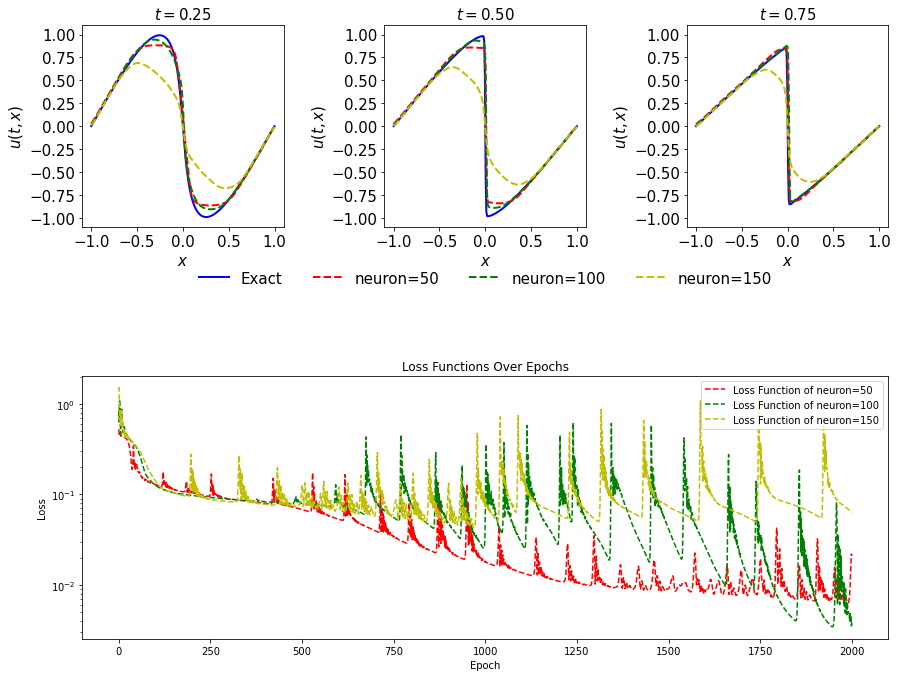

In [14]:
epochs = 2000

loss_1 = NN_1[0]
loss_2 = NN_2[0]
loss_3 = NN_3[0]

epoch_1 = NN_1[1]
epoch_2 = NN_2[1]
epoch_3 = NN_3[1]

pred_nn_11 = NN_1[2]
pred_nn_12 = NN_1[3]
pred_nn_13 = NN_1[4]

pred_nn_21 = NN_2[2]
pred_nn_22 = NN_2[3]
pred_nn_23 = NN_2[4]

pred_nn_31 = NN_3[2]
pred_nn_32 = NN_3[3]
pred_nn_33 = NN_3[4]

fig = plt.figure(figsize=(14, 16))
ax = fig.add_subplot(111)

ax_t = np.linspace(0, 1, 256)
ax_x = np.linspace(-1, 1, 256)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(ax_x, Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(ax_x, pred_nn_11[epochs][:,0], 'r--', linewidth = 2, label = 'neuron=50')
ax.plot(ax_x, pred_nn_21[epochs][:,0], 'g--', linewidth = 2, label = 'neuron=100')
ax.plot(ax_x, pred_nn_31[epochs][:,0], 'y--', linewidth = 2, label = 'neuron=150')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax = plt.subplot(gs1[0, 1])
ax.plot(ax_x, Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(ax_x, pred_nn_12[epochs][:,0], 'r--', linewidth = 2, label = 'neuron=50')
ax.plot(ax_x, pred_nn_22[epochs][:,0], 'g--', linewidth = 2, label = 'neuron=100')
ax.plot(ax_x, pred_nn_32[epochs][:,0], 'y--', linewidth = 2, label = 'neuron=150')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(ax_x, Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(ax_x, pred_nn_13[epochs][:,0], 'r--', linewidth = 2, label = 'neuron=50')
ax.plot(ax_x, pred_nn_23[epochs][:,0], 'g--', linewidth = 2, label = 'neuron=100')
ax.plot(ax_x, pred_nn_33[epochs][:,0], 'y--', linewidth = 2, label = 'neuron=150')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# 在新的一行中创建一个单独的子图
gs2 = gridspec.GridSpec(1, 1)
gs2.update(top=1-2.0/3.0-0.1, bottom=0.005, left=0.1, right=0.9, hspace=0.5)

ax_loss = plt.subplot(gs2[0, 0])
ax_loss.plot(epoch_1, loss_1, 'r--', label='Loss Function of neuron=50')
ax_loss.plot(epoch_2, loss_2, 'g--', label='Loss Function of neuron=100')
ax_loss.plot(epoch_3, loss_3, 'y--', label='Loss Function of neuron=150')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss Functions Over Epochs') 
ax_loss.legend(loc='upper right')

# 设置 y 轴为对数刻度
ax_loss.set_yscale('log')

plt.savefig('loss.png')
# plt.tight_layout()
plt.show()